# WGAN

In [1]:
import numpy as np
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import Constraint
import matplotlib.pyplot as plt

In [2]:
class ClipConstraint(Constraint):
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	def get_config(self):
		return {'clip_value': self.clip_value}

In [3]:
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

In [4]:
def define_critic(in_shape=(28,28,1)):
	init = RandomNormal(stddev=0.02)
	const = ClipConstraint(0.01)
	model = Sequential()
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dense(1))
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

In [5]:
def define_generator(latent_dim):
	init = RandomNormal(stddev=0.02)
	model = Sequential()
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
	return model

In [6]:
def define_gan(generator, critic):
	for layer in critic.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	model = Sequential()
	model.add(generator)
	model.add(critic)
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

In [7]:
def load_real_samples():
	(trainX, trainy), (_, _) = load_data()
	selected_ix = trainy == 7
	X = trainX[selected_ix]
	X = np.expand_dims(X, axis=-1)
	X = X.astype('float32')
	X = (X - 127.5) / 127.5
	return X

In [8]:
def generate_real_samples(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = -np.ones((n_samples, 1))
	return X, y

In [9]:
def generate_latent_points(latent_dim, n_samples):
	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = generator.predict(x_input)
	y = np.ones((n_samples, 1))
	return X, y

In [10]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	X = (X + 1) / 2.0
	for i in range(10 * 10):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.show()
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('=> Saved: %s and %s' % (filename1, filename2))

def plot_history(d1_hist, d2_hist, g_hist):
	plt.plot(d1_hist, label='crit_real')
	plt.plot(d2_hist, label='crit_fake')
	plt.plot(g_hist, label='gen')
	plt.legend()
	plt.savefig('plot_line_plot_loss.png')
	plt.show()

In [11]:
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	n_steps = bat_per_epo * n_epochs
	half_batch = int(n_batch / 2)
	c1_hist, c2_hist, g_hist = list(), list(), list()
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, n_steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
	for i in range(n_steps):
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			c_loss1 = c_model.train_on_batch(X_real, y_real)
			c1_tmp.append(c_loss1)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
			c2_tmp.append(c_loss2)
		c1_hist.append(np.mean(c1_tmp))
		c2_hist.append(np.mean(c2_tmp))
		X_gan = generate_latent_points(latent_dim, n_batch)
		y_gan = -np.ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		g_hist.append(g_loss)
		print('> Step %d: c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
		if (i+1) % bat_per_epo == 0:
			summarize_performance(i, g_model, latent_dim)
	plot_history(c1_hist, c2_hist, g_hist)

In [12]:
latent_dim = 50
critic = define_critic()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, critic)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [13]:
dataset = load_real_samples()
print(dataset.shape)

11501568/11490434 [==============================] - 0s 0us/step
(6265, 28, 28, 1)


n_epochs=10, n_batch=64, 1/2=32, b/e=97, n_steps=970
> Step 1: c1=-3.090, c2=0.068 g=-1.004
> Step 2: c1=-7.478, c2=0.165 g=-2.511
> Step 3: c1=-10.654, c2=0.253 g=-3.257
> Step 4: c1=-13.291, c2=0.315 g=-4.318
> Step 5: c1=-14.716, c2=0.352 g=-5.053
> Step 6: c1=-16.216, c2=0.405 g=-5.788
> Step 7: c1=-17.971, c2=0.443 g=-6.605
> Step 8: c1=-19.151, c2=0.492 g=-7.158
> Step 9: c1=-20.566, c2=0.556 g=-8.064
> Step 10: c1=-21.734, c2=0.618 g=-9.165
> Step 11: c1=-22.257, c2=0.720 g=-10.595
> Step 12: c1=-23.430, c2=0.776 g=-11.667
> Step 13: c1=-24.387, c2=0.903 g=-12.451
> Step 14: c1=-25.398, c2=0.968 g=-13.253
> Step 15: c1=-25.751, c2=1.060 g=-14.110
> Step 16: c1=-26.609, c2=1.159 g=-15.046
> Step 17: c1=-26.979, c2=1.208 g=-15.375
> Step 18: c1=-27.709, c2=1.290 g=-15.891
> Step 19: c1=-28.457, c2=1.319 g=-16.558
> Step 20: c1=-28.392, c2=1.370 g=-16.928
> Step 21: c1=-29.462, c2=1.400 g=-17.566
> Step 22: c1=-29.452, c2=1.441 g=-17.883
> Step 23: c1=-30.464, c2=1.417 g=-18.524
> 

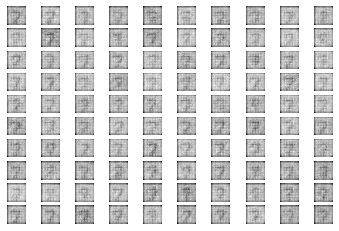

=> Saved: generated_plot_0097.png and model_0097.h5
> Step 98: c1=-75.171, c2=-66.560 g=-74.896
> Step 99: c1=-76.454, c2=-67.142 g=-75.037
> Step 100: c1=-77.530, c2=-68.106 g=-76.282
> Step 101: c1=-78.008, c2=-68.674 g=-77.684
> Step 102: c1=-78.305, c2=-69.740 g=-77.730
> Step 103: c1=-79.281, c2=-70.324 g=-78.476
> Step 104: c1=-80.849, c2=-71.469 g=-79.338
> Step 105: c1=-81.138, c2=-71.459 g=-80.390
> Step 106: c1=-81.181, c2=-72.844 g=-81.315
> Step 107: c1=-82.878, c2=-73.600 g=-82.019
> Step 108: c1=-82.545, c2=-74.398 g=-82.482
> Step 109: c1=-83.908, c2=-75.222 g=-84.071
> Step 110: c1=-84.801, c2=-75.819 g=-85.248
> Step 111: c1=-85.625, c2=-76.665 g=-85.559
> Step 112: c1=-86.341, c2=-77.490 g=-86.488
> Step 113: c1=-87.032, c2=-78.360 g=-87.369
> Step 114: c1=-88.100, c2=-79.142 g=-88.217
> Step 115: c1=-88.462, c2=-79.758 g=-88.100
> Step 116: c1=-89.041, c2=-80.951 g=-89.861
> Step 117: c1=-89.866, c2=-81.139 g=-90.484
> Step 118: c1=-91.104, c2=-82.386 g=-92.105
> Ste

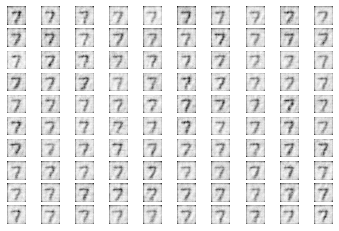

=> Saved: generated_plot_0194.png and model_0194.h5
> Step 195: c1=-152.405, c2=-146.744 g=-159.712
> Step 196: c1=-152.749, c2=-146.708 g=-158.836
> Step 197: c1=-154.168, c2=-148.617 g=-161.361
> Step 198: c1=-154.570, c2=-148.911 g=-162.777
> Step 199: c1=-156.160, c2=-149.666 g=-163.515
> Step 200: c1=-156.745, c2=-150.849 g=-164.433
> Step 201: c1=-156.974, c2=-151.742 g=-165.268
> Step 202: c1=-159.039, c2=-152.580 g=-166.163
> Step 203: c1=-159.330, c2=-153.482 g=-167.275
> Step 204: c1=-160.446, c2=-154.442 g=-167.834
> Step 205: c1=-160.849, c2=-155.356 g=-169.009
> Step 206: c1=-161.549, c2=-156.079 g=-169.717
> Step 207: c1=-163.134, c2=-157.215 g=-170.675
> Step 208: c1=-163.590, c2=-158.076 g=-171.744
> Step 209: c1=-164.073, c2=-158.801 g=-172.800
> Step 210: c1=-166.177, c2=-159.744 g=-173.317
> Step 211: c1=-166.796, c2=-160.827 g=-174.478
> Step 212: c1=-166.739, c2=-161.441 g=-175.484
> Step 213: c1=-167.747, c2=-162.109 g=-175.940
> Step 214: c1=-169.443, c2=-163.548

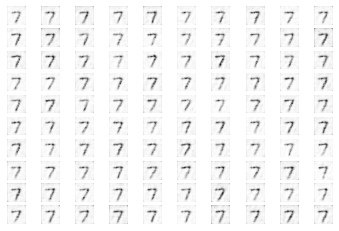

=> Saved: generated_plot_0291.png and model_0291.h5
> Step 292: c1=-239.811, c2=-235.643 g=-250.027
> Step 293: c1=-241.977, c2=-237.938 g=-252.159
> Step 294: c1=-243.099, c2=-238.198 g=-253.197
> Step 295: c1=-244.067, c2=-238.817 g=-253.276
> Step 296: c1=-244.810, c2=-240.756 g=-254.670
> Step 297: c1=-246.434, c2=-239.095 g=-255.471
> Step 298: c1=-246.081, c2=-241.634 g=-255.758
> Step 299: c1=-247.974, c2=-243.485 g=-257.904
> Step 300: c1=-249.514, c2=-242.496 g=-258.037
> Step 301: c1=-250.202, c2=-244.833 g=-259.920
> Step 302: c1=-251.775, c2=-245.255 g=-261.084
> Step 303: c1=-252.561, c2=-245.429 g=-261.570
> Step 304: c1=-253.291, c2=-247.372 g=-262.957
> Step 305: c1=-253.007, c2=-246.937 g=-262.114
> Step 306: c1=-254.722, c2=-250.546 g=-265.098
> Step 307: c1=-255.967, c2=-250.032 g=-266.128
> Step 308: c1=-256.487, c2=-249.271 g=-265.407
> Step 309: c1=-258.377, c2=-252.921 g=-267.595
> Step 310: c1=-258.347, c2=-253.711 g=-269.020
> Step 311: c1=-260.151, c2=-252.513

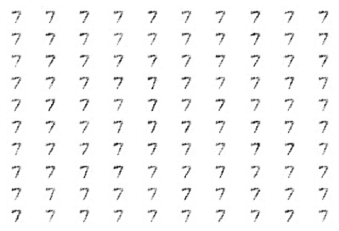

=> Saved: generated_plot_0388.png and model_0388.h5
> Step 389: c1=-312.196, c2=-298.836 g=-336.400
> Step 390: c1=-311.475, c2=-303.045 g=-338.161
> Step 391: c1=-311.371, c2=-294.507 g=-337.102
> Step 392: c1=-307.086, c2=-294.113 g=-334.021
> Step 393: c1=-311.266, c2=-303.988 g=-336.971
> Step 394: c1=-312.480, c2=-304.728 g=-339.768
> Step 395: c1=-308.119, c2=-283.024 g=-334.002
> Step 396: c1=-302.085, c2=-306.221 g=-339.281
> Step 397: c1=-302.301, c2=-287.198 g=-336.998
> Step 398: c1=-301.652, c2=-294.487 g=-338.703
> Step 399: c1=-300.543, c2=-278.945 g=-335.214
> Step 400: c1=-293.186, c2=-278.241 g=-335.000
> Step 401: c1=-296.619, c2=-279.621 g=-333.341
> Step 402: c1=-274.244, c2=-246.179 g=-325.681
> Step 403: c1=-266.731, c2=-252.318 g=-325.595
> Step 404: c1=-245.145, c2=-219.916 g=-317.085
> Step 405: c1=-227.422, c2=-192.245 g=-310.325
> Step 406: c1=-191.769, c2=-101.954 g=-296.756
> Step 407: c1=-159.014, c2=-33.211 g=-270.630
> Step 408: c1=-69.073, c2=26.283 g=-

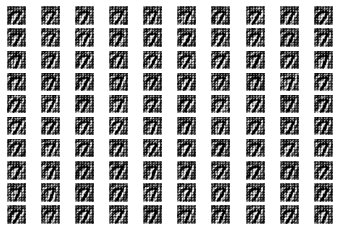

=> Saved: generated_plot_0485.png and model_0485.h5
> Step 486: c1=-382.110, c2=-350.257 g=282.895
> Step 487: c1=-385.296, c2=-351.572 g=291.574
> Step 488: c1=-386.309, c2=-352.049 g=299.403
> Step 489: c1=-389.182, c2=-356.069 g=308.727
> Step 490: c1=-391.488, c2=-359.293 g=318.397
> Step 491: c1=-393.849, c2=-364.303 g=323.367
> Step 492: c1=-395.730, c2=-368.549 g=330.025
> Step 493: c1=-398.914, c2=-370.364 g=335.606
> Step 494: c1=-400.666, c2=-372.799 g=340.818
> Step 495: c1=-403.108, c2=-377.398 g=344.966
> Step 496: c1=-405.705, c2=-379.492 g=345.702
> Step 497: c1=-406.365, c2=-380.377 g=349.784
> Step 498: c1=-410.193, c2=-383.746 g=353.654
> Step 499: c1=-410.906, c2=-386.490 g=358.403
> Step 500: c1=-414.556, c2=-389.105 g=359.350
> Step 501: c1=-416.741, c2=-391.785 g=361.144
> Step 502: c1=-418.880, c2=-394.821 g=366.587
> Step 503: c1=-419.768, c2=-396.613 g=367.776
> Step 504: c1=-422.520, c2=-398.711 g=370.152
> Step 505: c1=-423.970, c2=-400.397 g=372.845
> Step 5

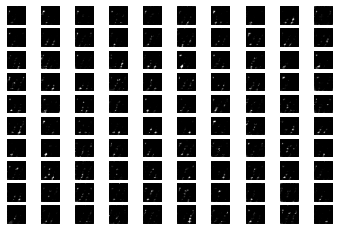

=> Saved: generated_plot_0582.png and model_0582.h5
> Step 583: c1=-542.388, c2=-503.372 g=503.690
> Step 584: c1=-543.628, c2=-504.547 g=504.927
> Step 585: c1=-545.175, c2=-505.680 g=506.159
> Step 586: c1=-545.358, c2=-506.761 g=507.369
> Step 587: c1=-548.939, c2=-508.042 g=508.616
> Step 588: c1=-548.990, c2=-509.148 g=509.810
> Step 589: c1=-550.910, c2=-510.520 g=511.071
> Step 590: c1=-551.439, c2=-511.462 g=512.163
> Step 591: c1=-553.355, c2=-512.628 g=513.345
> Step 592: c1=-554.719, c2=-513.598 g=514.688
> Step 593: c1=-556.350, c2=-514.851 g=515.742
> Step 594: c1=-557.722, c2=-515.985 g=517.134
> Step 595: c1=-557.623, c2=-517.035 g=518.291
> Step 596: c1=-559.146, c2=-518.236 g=519.261
> Step 597: c1=-560.433, c2=-519.102 g=520.510
> Step 598: c1=-561.751, c2=-520.816 g=521.755
> Step 599: c1=-564.448, c2=-522.281 g=523.180
> Step 600: c1=-564.945, c2=-523.651 g=524.321
> Step 601: c1=-567.269, c2=-524.983 g=525.555
> Step 602: c1=-567.649, c2=-526.118 g=526.780
> Step 6

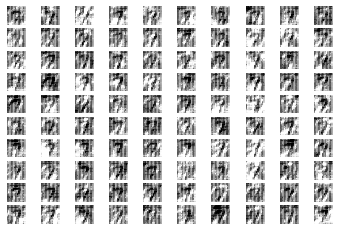

=> Saved: generated_plot_0679.png and model_0679.h5
> Step 680: c1=-601.228, c2=-473.472 g=483.252
> Step 681: c1=-603.105, c2=-480.125 g=492.812
> Step 682: c1=-614.929, c2=-491.558 g=499.393
> Step 683: c1=-617.934, c2=-500.562 g=510.901
> Step 684: c1=-620.797, c2=-507.987 g=519.984
> Step 685: c1=-625.375, c2=-514.721 g=527.026
> Step 686: c1=-631.971, c2=-519.321 g=526.318
> Step 687: c1=-635.480, c2=-524.465 g=537.487
> Step 688: c1=-637.157, c2=-531.975 g=550.218
> Step 689: c1=-639.996, c2=-539.839 g=556.948
> Step 690: c1=-643.041, c2=-544.426 g=561.188
> Step 691: c1=-646.703, c2=-547.462 g=569.797
> Step 692: c1=-648.460, c2=-547.007 g=571.644
> Step 693: c1=-652.301, c2=-556.394 g=581.034
> Step 694: c1=-653.209, c2=-552.333 g=581.800
> Step 695: c1=-655.013, c2=-558.109 g=586.723
> Step 696: c1=-657.309, c2=-553.597 g=589.580
> Step 697: c1=-658.707, c2=-567.874 g=595.746
> Step 698: c1=-659.924, c2=-570.327 g=595.855
> Step 699: c1=-661.885, c2=-575.890 g=600.507
> Step 7

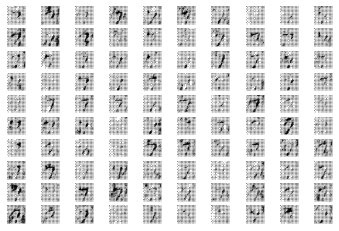

=> Saved: generated_plot_0776.png and model_0776.h5
> Step 777: c1=-695.353, c2=-584.100 g=521.140
> Step 778: c1=-695.878, c2=-583.492 g=502.289
> Step 779: c1=-693.749, c2=-580.101 g=501.622
> Step 780: c1=-698.648, c2=-591.933 g=492.956
> Step 781: c1=-695.535, c2=-596.071 g=476.868
> Step 782: c1=-700.463, c2=-596.871 g=432.610
> Step 783: c1=-694.495, c2=-583.706 g=400.023
> Step 784: c1=-692.917, c2=-570.814 g=331.154
> Step 785: c1=-687.813, c2=-545.446 g=245.073
> Step 786: c1=-678.051, c2=-510.791 g=98.164
> Step 787: c1=-660.671, c2=-440.937 g=-84.022
> Step 788: c1=-635.381, c2=-362.699 g=-219.673
> Step 789: c1=-604.781, c2=-319.530 g=-350.618
> Step 790: c1=-578.384, c2=-216.322 g=-373.974
> Step 791: c1=-543.566, c2=-228.383 g=-444.112
> Step 792: c1=-530.697, c2=-204.924 g=-442.085
> Step 793: c1=-535.219, c2=-177.088 g=-429.535
> Step 794: c1=-507.169, c2=-183.304 g=-433.267
> Step 795: c1=-494.719, c2=-184.109 g=-444.229
> Step 796: c1=-506.092, c2=-244.586 g=-452.269


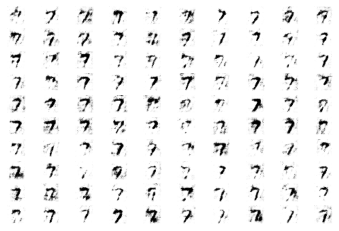

=> Saved: generated_plot_0873.png and model_0873.h5
> Step 874: c1=-373.632, c2=142.526 g=-280.435
> Step 875: c1=-358.992, c2=129.829 g=-286.368
> Step 876: c1=-368.431, c2=129.470 g=-293.207
> Step 877: c1=-370.599, c2=124.963 g=-288.345
> Step 878: c1=-347.016, c2=86.726 g=-291.441
> Step 879: c1=-344.464, c2=132.727 g=-286.233
> Step 880: c1=-356.532, c2=53.539 g=-305.178
> Step 881: c1=-349.821, c2=137.412 g=-300.995
> Step 882: c1=-343.898, c2=127.120 g=-296.789
> Step 883: c1=-332.638, c2=187.598 g=-295.965
> Step 884: c1=-351.782, c2=140.066 g=-297.240
> Step 885: c1=-357.357, c2=138.760 g=-296.324
> Step 886: c1=-352.285, c2=109.419 g=-318.335
> Step 887: c1=-330.262, c2=104.146 g=-316.939
> Step 888: c1=-348.915, c2=106.052 g=-326.270
> Step 889: c1=-338.436, c2=154.976 g=-309.977
> Step 890: c1=-353.830, c2=214.638 g=-310.622
> Step 891: c1=-367.207, c2=192.198 g=-292.562
> Step 892: c1=-346.365, c2=241.210 g=-304.759
> Step 893: c1=-354.594, c2=218.739 g=-287.324
> Step 894

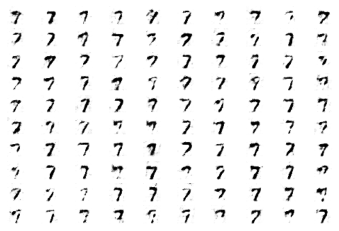

=> Saved: generated_plot_0970.png and model_0970.h5


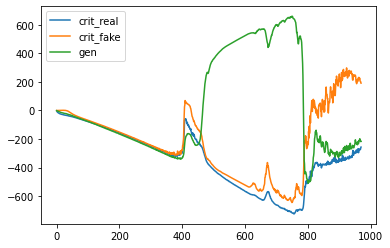

In [14]:
train(generator, critic, gan_model, dataset, latent_dim)